# Task 5.2D
**Computer Vision and Custom Vision**

The following notebook and report contains the code and explanations for building an application which can process a video file to tracking moving vehicles using Azure Cognitive Services Custom Vision.

A demonstration of the model can be found by following [this](https://1drv.ms/v/s!AtjXTZl9daVGpfoq8XreOpGq7dgBRQ?e=yFMuqc) link.

A link to the code repository this notebook and the resulting Python application can be found by following [this](https://github.com/BrentonAD/SIT788-Task5-2D) link.

## Table of Contents
- [Imort Modules](#import-modules)
- [Set-up](#set-up)
    - [Create a Custom Vision Resource](#create-a-custom-vision-resource)
    - [Configure Parameters](#configure-parameters)
    - [Copy Subscription Key and Endpoint](#copy-subscription-key-and-endpoint)
    - [Authenticate with Custom Vision Client](#authenticate-with-custom-vision-client)
- [Model Building](#model-building)
    - [Data Preparation](#data-preparation)
    - [Upload Labels to Custom Vision Project](#upload-labels-to-custom-vision-project)
    - [Train Model](#train-model)
    - [Publish the Trained Model](#publish-the-trained-model)
- [Build Video Predictor](#build-video-predictor)
    - [Source Video for Testing](#source-video-for-testing)
    - [Build Video Tester](#build-video-tester)
    - [Write Code to a Python File](#write-the-code-to-a-python-file)

---

# Import Modules <a class="anchor" id="import-modules"></a>

In [20]:
# These modules are used to interact with the operating system and perform basic tasks
import os
import glob
import io
import time

# These modules are used for applying operations onto large and vectorised data
import numpy as np
import pandas as pd

# Pillow is used for loading and drawing images in Python
from PIL import Image, ImageDraw, ImageFont

# OpenCV is used to handle and manipulate video
import cv2

# Azure Cognitive Services SDK for Custom Vision, used to interact with the Custom Vision Service
from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from azure.cognitiveservices.vision.customvision.training.models import (
    ImageFileCreateBatch,
    ImageFileCreateEntry,
    Region
)
from msrest.authentication import ApiKeyCredentials

# Config including the Endpoints and Subscription keys to the Custom Vision Service
import config

# Set-up <a class="anchor" id="set-up"></a>

## Create a Custom Vision Resource <a class="anchor" id="create-a-custom-vision-resource"></a>
In the Azure Portal, navigate to the Marketplace by selecting "Add Resource", search for Custom Vision and select "Create"

![create-a-custom-vision-resource](nb_images/create-a-custom-vision-resource.png)

## Configure Parameters <a class="anchor" id="configure-parameters"></a>
Configure the parameters of the computer vision resource. Note the location should be set to your closest available region. Also ensure to select both "Prediction" and "Training" options.

![configure-parameters](nb_images/configure-parameters.png)

## Copy Subscription Key and Endpoint <a class="anchor" id="copy-subscription-key-and-endpoint"></a>
After the deployment has been successful, navigate to the training resource and select "Keys and Endpoint" under "Resource Management" in the side panel. These will be used to authenticate with the service later in the notebook. Note that these are sensitive values, and should remain secret.

![copy-key-and-endpoint](nb_images/copy-key-and-endpoint.png)

Repeat the same for the prediction resource Endpoint, Subscription Key, and Resource ID

## Authenticate with Custom Vision Client <a class="anchor" id="authenticate-with-custom-vision-client"></a>

The below code is used to create the training and prediction clients for interacting with the respective components of the Azure Custom Vision service.

- **trainer**: Used to make API calls required for training a Custom Vision model such as uploading training images, start a training job, and publishing a model
- **predictor**: Used to send images for predictions once the model has been trained and published


In [2]:
training_credentials = ApiKeyCredentials(in_headers={"Training-key": config.TRAINING_KEY})
trainer = CustomVisionTrainingClient(config.TRAINING_ENDPOINT, training_credentials)

prediction_credentials = ApiKeyCredentials(in_headers={"Prediction-key": config.PREDICTION_KEY})
predictor = CustomVisionPredictionClient(config.PREDICTION_ENDPOINT, prediction_credentials)

# Model Building <a class="anchor" id="model-building"></a>

## Data Preparation <a class="anchor" id="data-preparation"></a>

The following code downloads an image dataset and prepares it to be sent to the Azure Custom Vision Service.

The data is sourced from [RoboFlow Vehicles-OpenImages](https://public.roboflow.com/object-detection/vehicles-openimages). It is available for use under the creative commons licence.

The dataset contains images of cars, buses, motorcycles, trucks, and ambulances all labelled with tags and bounding boxes using the [YOLOv8 Format](https://roboflow.com/formats/yolov8-pytorch-txt).

The image metadata has been loaded into a Pandas DataFrame and manipulated into the correct format for the Azure Custom Vision service.

In [3]:
os.makedirs("./data/",exist_ok=True)

In [ ]:
# Download the dataset from the public website
!curl -L "https://public.roboflow.com/ds/fifwrFoCU1?key=1sHciojzjl" > roboflow.zip; unzip roboflow.zip \
    -d ./data/; rm roboflow.zip

Loop through every label TXT file and extract class index label, and bounding box coordinates. Then, derive the corresponding image file path from the label path.

Collect all into one DataFrame ready for manipulation

In [15]:
data_directory = "./data"

labels_df_list = []
for filepath in glob.glob(f"{data_directory}/*/labels/*"):
    df = pd.read_csv(filepath,sep=" ", names=["class","center_x","center_y","width","height"])
    df["file_path"] = filepath.replace("labels","images")[:-4]+'.jpg'
    labels_df_list.append(df)

# Concatenate all files into one DataFrame
labels_df = pd.concat(labels_df_list)

Perform transformations on the given labels so they are in the format expected for Azure Customer Vision (outlined below):
- Tag name
- Left coordinate of bounding box
- top coordinate of bounding box
- width of bounding box
- height of bounding box

In [16]:
# Create a map from tag index to tag name
class_map = {0: "ambulance", 1:"bus", 2:"car", 3:"motorbike", 4:"truck"}

labels_df["tag"] = labels_df["class"].replace(class_map)
# Calculate left and top coordinate of bounding box
labels_df["left"] = (labels_df["center_x"]-labels_df["width"]/2).clip(lower=0)
labels_df["top"] = (labels_df["center_y"]-labels_df["height"]/2).clip(lower=0)

labels_df_reset = labels_df.reset_index()

In [17]:
# Filter the labels to only include three types of vehicles: Car, Bus, Truck
labels_df_filtered = labels_df_reset.loc[
    labels_df_reset["tag"].isin(["car","bus","truck"]),["file_path","tag","left","top","width","height"]
    ]

## Create a Custom Vision Project <a class="anchor" id="create-a-custom-vision-project"></a>

In [3]:
project_name = "Task-5.2D"

# Find the object detection domain, in this case use "General"
obj_detection_domain = next(domain for domain in trainer.get_domains() if domain.type == "ObjectDetection" and domain.name == "General")

# Find the existing projects, if one does not exist with the name then create it
existing_projects = {}
for project in trainer.get_projects():
    print(f"Name: {project.name}, ID: {project.id}")
    existing_projects[project_name] = project.id

if existing_projects.get(project_name):
    print("Project with that name already exists...")
    project = trainer.get_project(existing_projects[project_name])
else:
    # Create a new project
    print ("Creating project...")
    project = trainer.create_project(project_name, domain_id=obj_detection_domain.id)

Name: Task-5.2D, ID: e48e0601-d15b-4fe9-9110-40183b8c1aff
Project with that name already exists...


In [18]:
# Add tags to the project
car_tag = trainer.create_tag(project.id, "car")
bus_tag = trainer.create_tag(project.id, "bus")
truck_tag = trainer.create_tag(project.id, "truck")

## Upload Labels to Custom Vision Project <a class="anchor" id="upload-labels-to-custom-vision-project"></a>

In [19]:
# Map tag name to tag ID in the Azure Custom Vision project
tag_map = {"car":car_tag.id,"bus":bus_tag.id,"truck":truck_tag.id}

Firstly, group the Pandas DataFrame containing the metadata for images by the filename to ensure uploading one unique file.

Next, generate the bounding box regions for each row in the group, which correspond to an object in the given image.

Then, create the ImageFileCreateEntry object, which contains the binary image data and regions and append to the full list of images to be uploaded.

Finally, batch the list of images to be uploaded into groups of 64, as this is the largest amount that can be uploaded at once, and upload to images with regions the the Azure Custom Vision Service


In [20]:
tagged_images_with_regions = []
# Loop through each file in the metadata DataFrame
for file_path, rows in labels_df_filtered.groupby("file_path"):
    # Create regions from metadata rows
    regions = [ Region(
        tag_id=tag_map[row["tag"]],
        left=row["left"],
        top=row["top"],
        width=row["width"],
        height=row["height"]
        ) for _, row in rows.iterrows() ]
    # Open the image file as bytes
    with open(file_path, mode="rb") as image_contents:
        # Append the image contents and region to the list of images to be uploaded
        tagged_images_with_regions.append(
            ImageFileCreateEntry(
                name=file_path.rsplit('/', 1)[1],
                contents=image_contents.read(),
                regions=regions
                )
            )

# Find out how many (k) batches of 64 the list can be divided into
k, m = divmod(len(tagged_images_with_regions), 64)
image_tags = []
for i in range(k):
    # Upload the 64 images to the Azure Custom Vision service
    upload_result = trainer.create_images_from_files(
        project.id,
        ImageFileCreateBatch(images=tagged_images_with_regions[64*i:64*(i+1)])
    )

## Train Model <a class="anchor" id="train-model"></a>

In [ ]:
try:
    # Submit the training job
    iteration = trainer.train_project(project.id)
    while (iteration.status != "Completed"):
        # Get status of training every minute
        iteration = trainer.get_iteration(project.id, iteration.id)
        print ("Training status: " + iteration.status)
        time.sleep(60)
except:
    # If the training fails (for example, nothing has changed) get the latest iteration
    print("Training Failed, getting latest iteration")
    iteration = trainer.get_iterations(project.id)[0]

## Publish the Trained Model <a class="anchor" id="publish-the-trained-model"></a>

In [12]:
publish_iteration_name = "Task-5.2D-bct"

In [13]:
# The iteration is now trained. Publish it to the project endpoint
trainer.publish_iteration(project.id, iteration.id, publish_iteration_name, config.PREDICTION_RESOURCE_ID)

True

## Test the model with a sample image <a class="anchor" id="test-the-model-with-a-sample-image"></a>

	bus: 71.98%                 bbox.left = 0.91,                 bbox.top = 0.18,                 bbox.width = 0.09,                 bbox.height = 0.55
	bus: 49.59%                 bbox.left = 0.16,                 bbox.top = 0.13,                 bbox.width = 0.76,                 bbox.height = 0.69


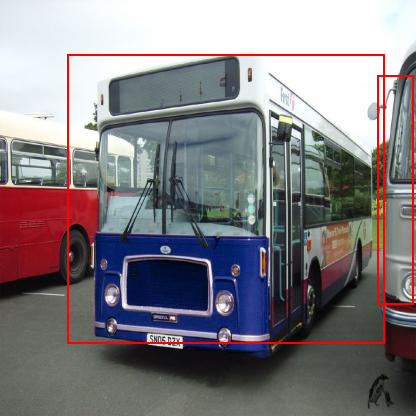

In [18]:
# Test the model with a sample image

# Now there is a trained endpoint that can be used to make a prediction

# Open the sample image and get back the prediction results.
test_image_url = os.path.join (data_directory,
                               "test",
                               "images",
                               "00e481ea1a520175_jpg.rf.MV6sZ8QCFwFeMYaI2tHm.jpg"
                            )
with open(test_image_url, mode="rb") as test_data:
    results = predictor.detect_image(project.id, publish_iteration_name, test_data)
 
# Plot the results
# Load the original image
image = Image.open(test_image_url)
# Create a layer to draw on top of the image
image_draw = ImageDraw.Draw(image)
for prediction in results.predictions:
    if prediction.probability>0.25:
        # Print the prediction details
        print("\t" + prediction.tag_name +
            f": {prediction.probability * 100:.2f}% \
                bbox.left = {prediction.bounding_box.left:.2f}, \
                bbox.top = {prediction.bounding_box.top:.2f}, \
                bbox.width = {prediction.bounding_box.width:.2f}, \
                bbox.height = {prediction.bounding_box.height:.2f}")
        # Draw the bounding box
        rectangle = [416*prediction.bounding_box.left,
                     416*prediction.bounding_box.top,
                     416*(prediction.bounding_box.left+prediction.bounding_box.width),
                     416*(prediction.bounding_box.top+prediction.bounding_box.height)]
        image_draw.rectangle(rectangle, outline="Red", width=2)

display(image)

# Build Video Predictor <a class="anchor" id="build-video-predictor"></a>

## Source Video for Testing <a class="anchor" id="source-video-for-testing"></a>

Video was sourced from: https://www.youtube.com/watch?v=MNn9qKG2UFI

The video contains highway traffic with a variety of different vehicles including the three target: bus, motorbike, and truck

The video was downloaded YouTube in accordance with the licence with the following command:

`youtube-dl -f 313 MNn9qKG2UFI`

Next the video was trimmed to timestamp 00:00:25.00 to 00:01:00.00 and converted into a usable format with the command

`ffmpeg -ss 00:00:25.00 -i '4K Road traffic video for object detection and tracking - free download now!-MNn9qKG2UFI.webm' -t 00:01:00.00 test_video.mp4`


## Build Video Tester <a class="anchor" id="build-video-tester"></a>

In [19]:
# Find the Custom Vision Project ID
for project in trainer.get_projects():
    print(f"Name: {project.name}, ID: {project.id}")

Name: Task-5.2D, ID: e48e0601-d15b-4fe9-9110-40183b8c1aff


The following code loads the video file using OpenCV. The video is then iterated over frame by frame.

As we only want to process the frames every 1 frame per second, calculate the actual frame per second (FPS) and find the ratio (hop) required to get to the key frames per second (KPS). When iterating over the frames of the video, only process it if the frame number is a multiple of the hop ratio. This will ensure that only 1 frame per second is processed but the video retains the same sequence of events.

When processing the frame, get the bytes of the current frame and use `predictor.detect_image()` to send them to the prediction Custom Vision Service. Store the prediction results. Also load the image into a Pillow Image so the bounding boxes can be drawn over.

For each predicted bounding box, check if the probability is greater than 25%. If it is, gather the bounding box and tag information from the prediction and draw the corresponding rectangle and text over the image. Note that the bounding box colour will be determined by the tag name.

Finally, convert the Pillow Image back into an OpenCV array and write to the VideoWrite. After the video file has been processed to the last frame, close the OpenCV connections to the input and output video files

In [25]:
# Set the Custom Vision Project ID
project_id = "e48e0601-d15b-4fe9-9110-40183b8c1aff"

# Set the font to use for the annotation
font = ImageFont.truetype("Arial Narrow Italic.ttf", 32)
# Configure the colour map from tag to boundary colour
tag_colour_map = {"bus":"Green","car":"Blue","truck":"Red"}

KPS = 1 # Target Keyframes Per Second
VIDEO_PATH = "test_video.mp4" #"path/to/video/folder"
OUTPUT_PATH = "test_video/predictions.mp4" #"path/to/output/folder"

# Initialise the OpenCV input and output streamer
cap = cv2.VideoCapture(VIDEO_PATH)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(OUTPUT_PATH, fourcc, 1, (3840,2160))

# Get the actual video frames per second
fps = round(cap.get(cv2.CAP_PROP_FPS))
# Calculate the ratio of FPS to KPS
hop = round(fps / KPS)
# Initialise the current frame number
curr_frame = 0
# Create a loop to iterate over frames
while(True):
    # Get the next frame
    ret, frame = cap.read()
    # If OpenCV can't read the frame (e.g. video ended) then exit out of the loop
    if not ret: break
    # Check if current frame number is a multiple of the hop ratio
    if curr_frame % hop == 0:
        # Get the bytes of the current frame image
        frameBytes = cv2.imencode(".jpg", frame)[1].tobytes()
        # Send image contents to the Custom Vision Service
        results = predictor.detect_image(project.id, publish_iteration_name, frameBytes)
        
        # Create a Pillow Image
        image = Image.open(io.BytesIO(frameBytes))
        # Create a layer to draw on top of the Image
        image_draw = ImageDraw.Draw(image)
        # Loop over each prediction
        for prediction in results.predictions:
            if prediction.probability>0.25:
                # Draw the bounding box
                rectangle = [3840*prediction.bounding_box.left,
                            2160*prediction.bounding_box.top,
                            3840*(prediction.bounding_box.left+prediction.bounding_box.width),
                            2160*(prediction.bounding_box.top+prediction.bounding_box.height)]
                image_draw.rectangle(rectangle, outline=tag_colour_map[prediction.tag_name], width=4)
                # Draw Text
                image_draw.text(
                    (3840*prediction.bounding_box.left, 2160*prediction.bounding_box.top-32),
                    f"Name: {prediction.tag_name}, Confidence: {prediction.probability*100:.2f}%",
                    fill="black",
                    font=font
                )
        # Convert the annotated image back into a format OpenCV can read
        new_frame = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        # Write the image to the video output
        out.write(new_frame)
        # Wait for 1 second to avoid excessive calls to the prediction API
        time.sleep(1)
    # Increment the current frame number
    curr_frame += 1

# After the video has ended, close the OpenCV connection
cap.release()
out.release()


30


## Write the Code to a Python File <a class="anchor" id="write-the-code-to-a-python-file"></a>

Write the video prediction code to a Python file with all of the required dependencies so that it can be used as a self contained application.

Notice the script accepts arguments from the command line.

In [2]:
%%writefile VehicleDetectionApp.py
import argparse
import io
import time

import numpy as np

from PIL import Image, ImageDraw, ImageFont
import cv2

from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from msrest.authentication import ApiKeyCredentials

import config

def main():
    parser = argparse.ArgumentParser()

    parser.add_argument("--project_id", type=str)
    parser.add_argument("--publish_iteration_name", type=str)
    parser.add_argument("--video_path", type=str)
    parser.add_argument("--output_path", type=str)
    
    args = parser.parse_args()
    
    # Set the Custom Vision Project ID
    project_id = args.project_id
    publish_iteration_name = args.publish_iteration_name

    # Authenticate with Azure Custom Vision Client
    prediction_credentials = ApiKeyCredentials(in_headers={"Prediction-key": config.PREDICTION_KEY})
    predictor = CustomVisionPredictionClient(config.PREDICTION_ENDPOINT, prediction_credentials)

    # Set the font to use for the annotation
    font = ImageFont.truetype("Arial Narrow Italic.ttf", 32)
    # Configure the colour map from tag to boundary colour
    tag_colour_map = {"bus":"Green","car":"Blue","truck":"Red"}

    KPS = 1 # Target Keyframes Per Second
    VIDEO_PATH = args.video_path #"path/to/video/folder"
    OUTPUT_PATH = args.output_path #"path/to/output/folder"

    # Initialise the OpenCV input and output streamer
    cap = cv2.VideoCapture(VIDEO_PATH)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(OUTPUT_PATH, fourcc, 1, (3840,2160))

    # Get the actual video frames per second
    fps = round(cap.get(cv2.CAP_PROP_FPS))
    # Calculate the ratio of FPS to KPS
    hop = round(fps / KPS)
    # Initialise the current frame number
    curr_frame = 0
    print("Reading video file")
    # Create a loop to iterate over frames
    while(True):
        # Get the next frame
        ret, frame = cap.read()
        # If OpenCV can't read the frame (e.g. video ended) then exit out of the loop
        if not ret: break
        # Check if current frame number is a multiple of the hop ratio
        if curr_frame % hop == 0:
            # Get the bytes of the current frame image
            frameBytes = cv2.imencode(".jpg", frame)[1].tobytes()
            # Send image contents to the Custom Vision Service
            results = predictor.detect_image(project_id, publish_iteration_name, frameBytes)
            
            # Create a Pillow Image
            image = Image.open(io.BytesIO(frameBytes))
            # Create a layer to draw on top of the Image
            image_draw = ImageDraw.Draw(image)
            # Loop over each prediction
            for prediction in results.predictions:
                if prediction.probability>0.25:
                    # Draw the bounding box
                    rectangle = [3840*prediction.bounding_box.left,
                                2160*prediction.bounding_box.top,
                                3840*(prediction.bounding_box.left+prediction.bounding_box.width),
                                2160*(prediction.bounding_box.top+prediction.bounding_box.height)]
                    image_draw.rectangle(rectangle, outline=tag_colour_map[prediction.tag_name], width=4)
                    # Draw Text
                    image_draw.text(
                        (3840*prediction.bounding_box.left, 2160*prediction.bounding_box.top-32),
                        f"Name: {prediction.tag_name}, Confidence: {prediction.probability*100:.2f}%",
                        fill="black",
                        font=font
                    )
            # Convert the annotated image back into a format OpenCV can read
            new_frame = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
            # Write the image to the video output
            out.write(new_frame)
            # Wait for 1 second to avoid excessive calls to the prediction API
            print("Processing...")
            time.sleep(1)
        # Increment the current frame number
        curr_frame += 1

    # After the video has ended, close the OpenCV connection
    cap.release()
    out.release()
    print("Object Detection Successful!")

if __name__ == '__main__':
    main()


Overwriting VehicleDetectionApp.py
